# References
## Flux
- [Flux model-zoo: conv.jl](https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl)
- [Flux model-zoo: lenet_mnist.jl](https://github.com/FluxML/model-zoo/blob/master/vision/lenet_mnist/lenet_mnist.jl)
- [Flux model-zoo: dcgan_mnist.jl](https://github.com/FluxML/model-zoo/blob/master/vision/dcgan_mnist/dcgan_mnist.jl)
- [Julia Flux Convolutional Neural Network Explained](https://spcman.github.io/getting-to-know-julia/deep-learning/vision/flux-cnn-zoo/)
- [Flux: regularisation](https://fluxml.ai/Flux.jl/stable/models/regularisation/)
- [Flux: saving](https://fluxml.ai/Flux.jl/stable/saving/)
- [Github: Model optimization fails (NaNs) with Zygote.pullback but works with Tracker.forward](https://github.com/FluxML/Flux.jl/issues/876)
- [Discourse: How come Flux.jl’s network parameters go to NaN?](https://discourse.julialang.org/t/how-come-flux-jls-network-parameters-go-to-nan/16439/4)
- [Discourse: How to do L2 regularization with new Flux and Zygote](https://discourse.julialang.org/t/how-to-do-l2-regularization-with-new-flux-and-zygote/31756/2)
- [Reddit: L1 Regularization Flux+CuArrays](https://www.reddit.com/r/Julia/comments/g5uxab/l1_regularization_fluxcuarrays/)

## tensorflow
- [Doc: KLDivergence](https://www.tensorflow.org/api_docs/python/tf/keras/losses/KLDivergence)

## keras
- [Github: kullback_leibler_divergence](https://github.com/keras-team/keras/blob/master/keras/losses.py#L711-L714)

## Image
- [SO: Reading image info in Julia without loading the images
](https://stackoverflow.com/questions/43188201/reading-image-info-in-julia-without-loading-the-images)
- [SO: image to array](https://stackoverflow.com/questions/59344708/strange-and-uninformative-error-in-my-simple-julia-flux-dense-model)
- [Githun: image to array(cifar10.jl)](https://github.com/FluxML/model-zoo/blob/master/vision/cifar10/cifar10.jl)

## IO
- [Github: read file](https://github.com/FluxML/Metalhead.jl/blob/sf/training/training/ImageNet/dataset.jl)

# Add packages

In [1]:
using Pkg
Pkg.installed()

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.4\Pkg\src\Pkg.jl:531


Dict{String,VersionNumber} with 6 entries:
  "BSON"          => v"0.2.6"
  "Images"        => v"0.22.2"
  "Plots"         => v"1.2.4"
  "DataFrames"    => v"0.21.0"
  "Flux"          => v"0.10.4"
  "ProgressMeter" => v"1.3.0"

```julia
# add required packages
used_packages = [
    "Flux", 
    "DataFrames", 
    "Images", 
    "Plots", 
    "Parameters",
    "TensorBoardLogger",
    "ProgressMeter",
    "DrWatson",
    "BSON"
]
Pkg.add(used_packages)
Pkg.installed()
```

# Import packages

In [3]:
## import packages
using Flux
import Flux.Data: DataLoader
import Flux: @epochs, onecold, onehotbatch, crossentropy
using DataFrames
using Images
using Plots
using ImageMagick
using Statistics
using Dates
using LinearAlgebra
using CuArrays
using Printf
import ProgressMeter
import BSON

# For KL divergence
# import Base: log

# include("./src/monkey.jl")
# import .monkey: read_label_discription, recursive_readdir, show_image, getarray

# Define useful functions

In [4]:
# read monkey_labels.txt
function read_label_discription(label_txt::String)::DataFrames.DataFrame
    
    # initialize
    column_names = [];
    content = [];

    # read text file
    for (i, line) in enumerate(eachline(label_txt))
        strings = strip.(split(line, ","));
        # println(strings, typeof(strings))
        if all(strings .== "")
            break
        end
        if i == 1
            append!(column_names, Symbol.(strings));
            continue
        end
        push!(content, String.(strings));
    end
    
    # convert 1d vector to 2d array (content has been transposed)
    content = reduce(hcat, content);

    # construct dataframe
    label_discription = DataFrames.DataFrame();
    for (i, name) in enumerate(column_names)
        if i > 3
            column = parse.(Int, content[i, :]);
            label_discription[!, name] =column;
        else
            label_discription[!, name] =content[i, :];
        end
    end

    return label_discription;
end


read_label_discription (generic function with 1 method)

In [5]:
# show image
function show_image(path::String; return_plot=false)
    img = Images.load(path);
    p = Plots.plot(img)
    display(p);
    if return_plot
        return p
    else
        return nothing
    end
end

show_image (generic function with 1 method)

In [6]:
# convert image to array
# https://stackoverflow.com/questions/59344708/strange-and-uninformative-error-in-my-simple-julia-flux-dense-model
# https://github.com/FluxML/model-zoo/blob/master/vision/cifar10/cifar10.jl
function getarray(path::String; img_size=(100, 100))::Array
    # img_size: (height, width)
    
    # code to get image based on the number and convert it to float
    file = Images.load(path)
    if ~isnothing(img_size)
        file = Images.imresize(file, img_size...)
    end
    X = convert(Array{Float64}, Images.channelview(file))
    # X = permutedims(X, (2, 3, 1))  # (channel, height, width) to (height, width, channel)
    X = permutedims(X, (3, 2, 1))  # (channel, height, width) to (width, height, channel)
    
    return X
end

getarray (generic function with 1 method)

In [7]:
# https://github.com/FluxML/Metalhead.jl/blob/sf/training/training/ImageNet/dataset.jl
function recursive_readdir(root::String; ext=nothing)::Array
    if !isnothing(ext) && ext[1] != "."
        ext = "." * ext
    end
    ret = String[]
    for (r, dirs, files) in walkdir(root)
        for f in files
            relative_path = relpath(joinpath(r, f));
            if isnothing(ext)
                push!(ret, relative_path);
            elseif splitext(relative_path)[end] == ext
                push!(ret, relative_path);
            end
        end
    end
    return ret
end

recursive_readdir (generic function with 1 method)

In [8]:
# https://stackoverflow.com/questions/43188201/reading-image-info-in-julia-without-loading-the-images
function get_imgs_size_info(imgs_path)
    wand = MagickWand()
    imgs_size = Tuple[]
    for img_path in imgs_path
        ImageMagick.pingimage(wand, img_path)
        push!(imgs_size, size(wand))  # (width, height)
    end
    info = DataFrame(path=imgs_path, size=imgs_size);
    return info
end

get_imgs_size_info (generic function with 1 method)

In [9]:
function resize_save_imgs(info_train_raw, train_raw_imgs_path, valid_raw_imgs_path;
                          train_img_width=150, do_process=true)
    
    train_img_height = floor(Int, train_img_width * mean(last.(info_train_raw.size)) / mean(first.(info_train_raw.size)));
    train_img_size = (train_img_width, train_img_height)

    train_imgs_path = replace.(train_raw_imgs_path, r"raw" => s"processed");
    if do_process
        processed_train_imgs = imresize.(load.(train_raw_imgs_path), reverse(train_img_size)...);
        @. mkpath(dirname(train_imgs_path));
        Images.save.(train_imgs_path, processed_train_imgs);
    end

    
    valid_imgs_path = replace.(valid_raw_imgs_path, r"raw" => s"processed");
    if do_process
        processed_valid_imgs = imresize.(load.(valid_raw_imgs_path), reverse(train_img_size)...);
        @. mkpath(dirname(valid_imgs_path));
        Images.save.(valid_imgs_path, processed_valid_imgs);
    end
    
    return train_imgs_path, valid_imgs_path, train_img_size
end

resize_save_imgs (generic function with 1 method)

# Setting parameters

In [10]:
## setting
data_dir = joinpath("data");

label_txt = joinpath(data_dir, "monkey_labels.txt");

raw_data_dir = joinpath(data_dir, "raw");
processed_dir = joinpath(data_dir, "processed");

train_raw_data_dir = joinpath(raw_data_dir, "training");
valid_raw_data_dir = joinpath(raw_data_dir, "validation");
# train_data_dir = joinpath(processed_dir, "training");
# valid_data_dir = joinpath(processed_dir, "validation");

train_raw_imgs_path = recursive_readdir(train_raw_data_dir; ext="jpg");
valid_raw_imgs_path = recursive_readdir(valid_raw_data_dir; ext="jpg");

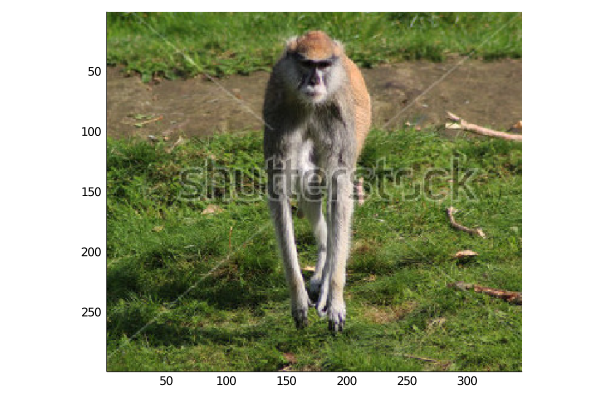

,Label,Latin Name,Common Name,Train Images,Validation Images
,String,String,String,Int64,Int64
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27


In [11]:
# read monkey_labels.txt
label_discription = read_label_discription(label_txt);

# show ranfom image
idx = rand(1:lastindex(train_raw_imgs_path));
show_image(train_raw_imgs_path[idx]; return_plot=false);
label_discription

# Preprocess
## Read image information

In [12]:
info_train_raw = get_imgs_size_info(train_raw_imgs_path);

In [13]:
# Show the number of images with width greater than height
println("Number of images with width greater than height: ", sum(first.(info_train_raw.size) .> last.(info_train_raw.size)))
println("Number of images with height greater than width: ", sum(first.(info_train_raw.size) .< last.(info_train_raw.size)))
first(info_train_raw, 5)

Number of images with width greater than height: 811
Number of images with height greater than width: 253


,path,size
,String,Tuple
1,data\\raw\\training\\n0\\n0018.jpg,"(550, 367)"
2,data\\raw\\training\\n0\\n0019.jpg,"(1920, 1080)"
3,data\\raw\\training\\n0\\n0020.jpg,"(337, 450)"
4,data\\raw\\training\\n0\\n0021.jpg,"(4367, 2911)"
5,data\\raw\\training\\n0\\n0022.jpg,"(1526, 1900)"


## Define the image size of the input neural network and save resized images

In [14]:
train_img_width = 150;
train_imgs_path, valid_imgs_path, train_img_size = resize_save_imgs(
    info_train_raw, train_raw_imgs_path, valid_raw_imgs_path;
    train_img_width=train_img_width, do_process=false
);

# Read data for tainging and validation

In [15]:
# read training images and labels
tmp_imgs = getarray.(train_imgs_path; img_size=nothing);

num_img = length(tmp_imgs);
train_imgs = Array{Float32, 4}(undef, train_img_size..., 3, num_img);
for i in 1:num_img
    train_imgs[:, :, :, i] = convert(Array{Float32}, popfirst!(tmp_imgs));
end
train_labels = reduce(hcat, splitpath.(dirname.(train_imgs_path)))[end, :];
train_labels = onehotbatch(train_labels, unique(train_labels))

# read validation images and labels
tmp_imgs = getarray.(valid_imgs_path; img_size=nothing);
num_img = length(tmp_imgs);
valid_imgs = Array{Float32, 4}(undef, train_img_size..., 3, num_img);
for i in 1:num_img
    valid_imgs[:, :, :, i] = convert(Array{Float32}, popfirst!(tmp_imgs));
end

valid_labels = reduce(hcat, splitpath.(dirname.(valid_imgs_path)))[end, :];
valid_labels = onehotbatch(valid_labels, unique(valid_labels));

train_imgs = train_imgs |> gpu;
train_labels = train_labels |> gpu;
valid_imgs = valid_imgs |> gpu;
valid_labels = valid_labels |> gpu;

# NN

### assist in building NN model

In [16]:
Flux.outdims(
    Chain(
        Conv((3, 3), 3=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),
        Conv((3, 3), 32=>64, pad=(1, 1), relu),
        Conv((3, 3), 64=>128, pad=(1, 1), relu),
        MaxPool((2, 2)),
        Conv((3, 3), 128=>128, pad=(1, 1), relu),
        Conv((3, 3), 128=>64, pad=(1, 1), relu),
        MaxPool((2, 2)),
        Conv((3, 3), 64=>32, pad=(1, 1), relu),
        Conv((3, 3), 32=>16, pad=(1, 1), relu),
        MaxPool((2, 2))),
    (123, 150)
)

Flux.outdims(
    Chain(
        Conv((3, 3), 3=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),
        Conv((3, 3), 32=>64, pad=(1, 1), relu),
        MaxPool((2, 2)),
        Conv((3, 3), 64=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),
        Conv((3, 3), 32=>16, pad=(1, 1), relu),
        MaxPool((2, 2))),
    (150, 123)
)

(9, 7)

## build NN model

In [17]:
## build NN model
function my_model(;complex=false)
    if complex
        return model = Chain(
            
            BatchNorm(3),
            Conv((3, 3), 3=>32, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            Conv((3, 3), 32=>64, pad=(1, 1), leakyrelu),
            
            BatchNorm(64),
            Conv((3, 3), 64=>128, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            Conv((3, 3), 128=>128, pad=(1, 1), leakyrelu),
            
            BatchNorm(128),
            Conv((3, 3), 128=>64, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            Conv((3, 3), 64=>32, pad=(1, 1), leakyrelu),
            
            BatchNorm(32),
            Conv((3, 3), 32=>16, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            Flux.flatten,
            Dense(1008, 128, leakyrelu),
            
            BatchNorm(128),
            Dense(128, 10),
            softmax
        )
    else
        return model = Chain(
            
            BatchNorm(3),
            Conv((3, 3), 3=>32, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            
            BatchNorm(32),
            Conv((3, 3), 32=>64, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            
            BatchNorm(64),
            Conv((3, 3), 64=>32, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            
            BatchNorm(32),
            Conv((3, 3), 32=>16, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            Flux.flatten,
            Dense(1008, 128, leakyrelu),
            
            BatchNorm(128),
            Dense(128, 10),
            softmax
        )
    end
end

my_model (generic function with 1 method)

 ## loss function

In [18]:
## cross entropy

# loss(x, y) = Flux.crossentropy(model(x), y);

augment(x) = x .+ gpu(0.1f0 * randn(eltype(x), size(x)))
function loss(x, y)
    x̂ = augment(x)
    ŷ = model(x̂)
    return crossentropy(ŷ, y)
end

## kldivergence
function kldivergence(ŷ, y)
    y = clamp.(y, eps(Float32), Inf32);
    ŷ = clamp.(ŷ, eps(Float32), Inf32);
    entropy = sum(y .* log.(y)) * 1 //size(y,2)
    cross_entropy = crossentropy(ŷ, y)
    return entropy + cross_entropy
end

# Re-definition to fix interaction with CuArrays.
CuArrays.@cufunc kldivergence(ŷ, y) = begin
    y = clamp.(y, eps(Float32), Inf32);
    ŷ = clamp.(ŷ, eps(Float32), Inf32);
    entropy = sum(y .* log.(y)) * 1 //size(y,2)
    cross_entropy = crossentropy(ŷ, y)
    entropy + cross_entropy
end

# test
# > y_true = [[0 1]; [0 0]]
# > y_pred = [[0.6 0.4]; [0.4 0.6]]
# > kldivergence(y_pred, y_true)
# 0.548

# loss(x, y) = kldivergence(model(x), y);

# augment(x) = x .+ gpu(0.1f0 * randn(eltype(x), size(x)))
# function loss(x, y)
#     x̂ = augment(x)
#     ŷ = model(x̂)
#     return kldivergence(ŷ, y)
# end

## callback function

In [19]:
# ## callback function
# # for Flux.train!

# struct StopException <: Exception end
# Base.showerror(io::IO, e::StopException) = print(io, "Early stop!")
# # try
# #     throw(StopException())
# # catch ex
# #     if ex isa StopException
# #         rethrow(ex)
# #     end
# # end

# valid_loss = typemax(Float32)
# num_early_stop, early_stop = 0, 4
# function evalcb()

#     valid_loss_tmp, acc = @show(eval_loss_accuracy())
#     if valid_loss_tmp > valid_loss
#         global num_early_stop += 1
#     else
#         global num_early_stop = 0
#     end
#     @printf("Number of early stop: %i\n", num_early_stop)
#     num_early_stop > early_stop && throw(StopException)
    
#     global valid_loss = valid_loss_tmp
# end

## evalution function

In [20]:
## evalution function
# accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

function eval_loss_accuracy(data_loader, model)
    testmode!(model)
    l = 0f0
    acc = 0
    ntot = 0
    for (x, y) in data_loader
        l += loss(x, y) * size(x)[end]
        acc += sum(onecold(model(x) |> cpu) .== onecold(y |> cpu))
        ntot += size(x)[end]
    end
    testmode!(model, false)
    return (loss = l/ntot,
            acc = acc/ntot)
end

eval_loss_accuracy (generic function with 1 method)

## hyper parameters

In [21]:
## hyper parameters
num_epochs = 500;
batchsize = 64;
learining_rate = 0.01;
decay = 0.8;
decay_step = 10;
clip = 1e-4;
l2_factor = 0.001;
early_stop = 50;

# Data Loader

In [22]:
## DataLoader
train_loader = DataLoader(
    train_imgs, train_labels; batchsize=batchsize, shuffle=true
);
valid_loader = DataLoader(
    valid_imgs, valid_labels, batchsize=batchsize
);

## training

In [23]:
for use_complex_model in [false, true]
    
    global model = my_model(complex=use_complex_model) |> gpu;
    global optimiser = Flux.Optimiser(ADAM(learining_rate, (0.9, 0.999)), WeightDecay(l2_factor))
    
    global best_acc = 0.0;
    global last_improvement = 0;
    global num_early_stop = 0;
    
    @info("Start training loop...")

    for epoch_idx in 1:num_epochs
        global best_acc, last_improvement
        p = ProgressMeter.Progress(length(train_loader); desc="Epoch [$epoch_idx]:")

        # Train for a single epoch
        for (x, y) in train_loader
            gs = Flux.gradient(params(model)) do
                loss(x, y)
            end
            Flux.Optimise.update!(optimiser, params(model), gs)
            ProgressMeter.next!(p)   # comment out for no progress bar
        end


        # Calculate accuracy:
        _loss, acc = eval_loss_accuracy(valid_loader, model)
        println("Epoch [$epoch_idx]:  Validation loss = $_loss,  Validation acc = $acc")

        # Early stop: If our accuracy is good enough, quit out.
        if acc >= 0.97
            @info(" -> Early-exiting: We reached our target accuracy of 97%")
            break
        end

        # If this is the best accuracy we've seen so far, save the model out
        if acc >= best_acc
            
            savepath = joinpath(".", "models");
            if use_complex_model
                model_filename = @sprintf("monkey_complex_acc[%03d%%].bson", acc*100)
            else
                model_filename = @sprintf("monkey_simple_acc[%03d%%].bson", acc*100)
            end
            
            !ispath(savepath) && mkpath(savepath)
            modelpath = joinpath(savepath, model_filename)
            println(@sprintf(" -> New best accuracy! Saving model out to %s", modelpath))
            let model = cpu(model)
                BSON.@save modelpath model epoch_idx acc
            end
            best_acc = acc
            last_improvement = epoch_idx
            num_early_stop = 0;
        else
            num_early_stop += 1;
        end

        if epoch_idx - last_improvement >= decay_step && optimiser.os[1].eta > clip
            optimiser.os[1].eta *= decay
            
            # After dropping learning rate, give it a few epochs to improve
            last_improvement = epoch_idx

            if optimiser.os[1].eta <= clip
               optimiser.os[1].eta = clip
            end
            @warn(" -> Haven't improved in a while, dropping learning rate to $(optimiser.os[1].eta)!")
        end

        # Early stop: no improvement
        if num_early_stop >= early_stop
            @warn(" -> No improvement, stop training.")
            break
        end
        
        if isnan(_loss)
            @warn(" -> The loss becomes NaN!")
            break
        end
    end
    
end

┌ Info: Start training loop...
└ @ Main In[23]:12
Epoch [1]:100%|█████████████████████████████████████████| Time: 0:01:12


Epoch [1]:  Validation loss = 2.9375982,  Validation acc = 0.12867647058823528
 -> New best accuracy! Saving model out to .\models\monkey_simple_acc[013%].bson


Epoch [2]:100%|█████████████████████████████████████████| Time: 0:00:03


Epoch [2]:  Validation loss = 1.3558105,  Validation acc = 0.47058823529411764
 -> New best accuracy! Saving model out to .\models\monkey_simple_acc[047%].bson


Epoch [3]:100%|█████████████████████████████████████████| Time: 0:00:03

Epoch [3]:  Validation loss = 1.2562228,  Validation acc = 0.4485294117647059

Epoch [4]:100%|█████████████████████████████████████████| Time: 0:00:03


Epoch [4]:  Validation loss = 1.1839881,  Validation acc = 0.5294117647058824
 -> New best accuracy! Saving model out to .\models\monkey_simple_acc[053%].bson


Epoch [5]:100%|█████████████████████████████████████████| Time: 0:00:03


Epoch [5]:  Validation loss = 1.1700158,  Validation acc = 0.5919117647058824
 -> New best accuracy! Saving model out to .\models\monkey_simple_acc[059%].bson


Epoch [6]:100%|█████████████████████████████████████████| Time: 0:00:03


Epoch [6]:  Validation loss = 1.1367867,  Validation acc = 0.5477941176470589

Epoch [7]:  6%|███                                      |  ETA: 0:00:03

Epoch [7]:100%|█████████████████████████████████████████| Time: 0:00:03

Epoch [7]:  Validation loss = 1.1875303,  Validation acc = 0.5477941176470589



Epoch [8]:100%|█████████████████████████████████████████| Time: 0:00:04


Epoch [8]:  Validation loss = 1.4979142,  Validation acc = 0.5

Epoch [9]:  6%|███                                      |  ETA: 0:00:04

Epoch [9]:100%|█████████████████████████████████████████| Time: 0:00:04


Epoch [9]:  Validation loss = 1.0400561,  Validation acc = 0.5625

Epoch [10]:  6%|███                                     |  ETA: 0:00:04

Epoch [10]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [10]:  Validation loss = 1.0670664,  Validation acc = 0.6102941176470589
 -> New best accuracy! Saving model out to .\models\monkey_simple_acc[061%].bson


Epoch [11]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [11]:  Validation loss = 1.1292169,  Validation acc = 0.5882352941176471


Epoch [12]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [12]:  Validation loss = 1.0156407,  Validation acc = 0.6544117647058824
 -> New best accuracy! Saving model out to .\models\monkey_simple_acc[065%].bson


Epoch [13]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [13]:  Validation loss = 1.014803,  Validation acc = 0.6029411764705882

Epoch [14]:  6%|███                                     |  ETA: 0:00:04

Epoch [14]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [14]:  Validation loss = 2.4501984,  Validation acc = 0.46691176470588236

Epoch [15]:  6%|███                                     |  ETA: 0:00:04

Epoch [15]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [15]:  Validation loss = 1.4527459,  Validation acc = 0.6433823529411765

Epoch [16]:  6%|███                                     |  ETA: 0:00:04

Epoch [16]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [16]:  Validation loss = 1.1579788,  Validation acc = 0.6286764705882353

Epoch [17]:  6%|███                                     |  ETA: 0:00:04

Epoch [17]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [17]:  Validation loss = 1.1217496,  Validation acc = 0.6507352941176471

Epoch [18]:  6%|███                                     |  ETA: 0:00:04

Epoch [18]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [18]:  Validation loss = 1.100218,  Validation acc = 0.6875
 -> New best accuracy! Saving model out to .\models\monkey_simple_acc[069%].bson


Epoch [19]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [19]:  Validation loss = 1.1443624,  Validation acc = 0.625


Epoch [20]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [20]:  Validation loss = 1.4875027,  Validation acc = 0.625

Epoch [21]:  6%|███                                     |  ETA: 0:00:04

Epoch [21]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [21]:  Validation loss = 1.0733995,  Validation acc = 0.6691176470588235

Epoch [22]:  6%|███                                     |  ETA: 0:00:04

Epoch [22]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [22]:  Validation loss = 1.5529749,  Validation acc = 0.5992647058823529

Epoch [23]:  6%|███                                     |  ETA: 0:00:04

Epoch [23]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [23]:  Validation loss = 1.6498611,  Validation acc = 0.5514705882352942

Epoch [24]:  6%|███                                     |  ETA: 0:00:04

Epoch [24]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [24]:  Validation loss = 1.2032557,  Validation acc = 0.6654411764705882


Epoch [25]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [25]:  Validation loss = 1.2627536,  Validation acc = 0.6544117647058824


Epoch [26]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [26]:  Validation loss = 1.1842276,  Validation acc = 0.5661764705882353


Epoch [27]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [27]:  Validation loss = 1.1535853,  Validation acc = 0.6948529411764706


Epoch [28]:  6%|███                                     |  ETA: 0:00:04

 -> New best accuracy! Saving model out to .\models\monkey_simple_acc[069%].bson


Epoch [28]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [28]:  Validation loss = 1.4294543,  Validation acc = 0.6580882352941176

Epoch [29]:  6%|███                                     |  ETA: 0:00:04

Epoch [29]:100%|████████████████████████████████████████| Time: 0:00:03
Epoch [30]:  6%|███                                     |  ETA: 0:00:04

Epoch [29]:  Validation loss = 1.2548728,  Validation acc = 0.6838235294117647


Epoch [30]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [30]:  Validation loss = 1.0770662,  Validation acc = 0.6764705882352942


Epoch [31]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [31]:  Validation loss = 1.2789717,  Validation acc = 0.6507352941176471


Epoch [32]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [32]:  Validation loss = 1.16629,  Validation acc = 0.6580882352941176


Epoch [33]:100%|████████████████████████████████████████| Time: 0:00:03
Epoch [34]:  6%|███                                     |  ETA: 0:00:04

Epoch [33]:  Validation loss = 1.6003139,  Validation acc = 0.5625


Epoch [34]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [34]:  Validation loss = 1.3152965,  Validation acc = 0.6102941176470589

Epoch [35]:  6%|███                                     |  ETA: 0:00:04

Epoch [35]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [35]:  Validation loss = 1.2826185,  Validation acc = 0.6617647058823529

Epoch [36]:  6%|███                                     |  ETA: 0:00:04

Epoch [36]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [36]:  Validation loss = 1.3451519,  Validation acc = 0.6139705882352942

Epoch [37]:  6%|███                                     |  ETA: 0:00:04

Epoch [37]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [37]:  Validation loss = 1.4649347,  Validation acc = 0.6544117647058824


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.008!
└ @ Main In[23]:82
Epoch [38]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [38]:  Validation loss = 1.2055786,  Validation acc = 0.6433823529411765

Epoch [39]:  6%|███                                     |  ETA: 0:00:04

Epoch [39]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [39]:  Validation loss = 1.1290399,  Validation acc = 0.7132352941176471
 -> New best accuracy! Saving model out to .\models\monkey_simple_acc[071%].bson


Epoch [40]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [40]:  Validation loss = 1.0287235,  Validation acc = 0.7316176470588235


Epoch [41]:  6%|███                                     |  ETA: 0:00:04

 -> New best accuracy! Saving model out to .\models\monkey_simple_acc[073%].bson


Epoch [41]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [41]:  Validation loss = 1.0785395,  Validation acc = 0.7389705882352942
 -> New best accuracy! Saving model out to .\models\monkey_simple_acc[074%].bson


Epoch [42]:100%|████████████████████████████████████████| Time: 0:00:04
Epoch [43]:  6%|███                                     |  ETA: 0:00:04

Epoch [42]:  Validation loss = 1.0620412,  Validation acc = 0.7022058823529411


Epoch [43]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [43]:  Validation loss = 1.0108178,  Validation acc = 0.7169117647058824

Epoch [44]:  6%|███                                     |  ETA: 0:00:04

Epoch [44]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [44]:  Validation loss = 1.2030121,  Validation acc = 0.6875

Epoch [45]:  6%|███                                     |  ETA: 0:00:04

Epoch [45]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [45]:  Validation loss = 1.325151,  Validation acc = 0.5955882352941176

Epoch [46]:  6%|███                                     |  ETA: 0:00:04

Epoch [46]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [46]:  Validation loss = 1.5920064,  Validation acc = 0.6286764705882353


Epoch [47]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [47]:  Validation loss = 1.0807695,  Validation acc = 0.6948529411764706

Epoch [48]:  6%|███                                     |  ETA: 0:00:04

Epoch [48]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [48]:  Validation loss = 1.100127,  Validation acc = 0.7132352941176471


Epoch [49]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [49]:  Validation loss = 1.1204957,  Validation acc = 0.6985294117647058

Epoch [50]:  6%|███                                     |  ETA: 0:00:04

Epoch [50]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [50]:  Validation loss = 1.2568195,  Validation acc = 0.6360294117647058

Epoch [51]:  6%|███                                     |  ETA: 0:00:04

Epoch [51]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [51]:  Validation loss = 1.3420918,  Validation acc = 0.6507352941176471


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.0064!
└ @ Main In[23]:82
Epoch [52]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [52]:  Validation loss = 1.2437642,  Validation acc = 0.6801470588235294

Epoch [53]:  6%|███                                     |  ETA: 0:00:04

Epoch [53]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [53]:  Validation loss = 1.1631343,  Validation acc = 0.7022058823529411

Epoch [54]:  6%|███                                     |  ETA: 0:00:04

Epoch [54]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [54]:  Validation loss = 1.2580351,  Validation acc = 0.6286764705882353

Epoch [55]:  6%|███                                     |  ETA: 0:00:04

Epoch [55]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [55]:  Validation loss = 1.1691446,  Validation acc = 0.6948529411764706


Epoch [56]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [56]:  Validation loss = 1.313412,  Validation acc = 0.5808823529411765

Epoch [57]:  6%|███                                     |  ETA: 0:00:04

Epoch [57]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [57]:  Validation loss = 1.0910517,  Validation acc = 0.6911764705882353

Epoch [58]:  6%|███                                     |  ETA: 0:00:04

Epoch [58]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [58]:  Validation loss = 1.1721228,  Validation acc = 0.7352941176470589

Epoch [59]:  6%|███                                     |  ETA: 0:00:04

Epoch [59]:100%|████████████████████████████████████████| Time: 0:00:03
Epoch [60]:  6%|███                                     |  ETA: 0:00:04

Epoch [59]:  Validation loss = 1.0938748,  Validation acc = 0.7352941176470589


Epoch [60]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [60]:  Validation loss = 1.2481893,  Validation acc = 0.6691176470588235

Epoch [61]:  6%|███                                     |  ETA: 0:00:03

Epoch [61]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [61]:  Validation loss = 1.3658416,  Validation acc = 0.6176470588235294


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.00512!
└ @ Main In[23]:82
Epoch [62]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [62]:  Validation loss = 1.225867,  Validation acc = 0.6213235294117647

Epoch [63]:  6%|███                                     |  ETA: 0:00:03

Epoch [63]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [63]:  Validation loss = 1.099669,  Validation acc = 0.7316176470588235

Epoch [64]:  6%|███                                     |  ETA: 0:00:04

Epoch [64]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [64]:  Validation loss = 1.0107548,  Validation acc = 0.7058823529411765

Epoch [65]:  6%|███                                     |  ETA: 0:00:04

Epoch [65]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [65]:  Validation loss = 1.0277431,  Validation acc = 0.7316176470588235

Epoch [66]:  6%|███                                     |  ETA: 0:00:04

Epoch [66]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [66]:  Validation loss = 1.2433974,  Validation acc = 0.6875

Epoch [67]:  6%|███                                     |  ETA: 0:00:04

Epoch [67]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [67]:  Validation loss = 1.0944953,  Validation acc = 0.7095588235294118

Epoch [68]:  6%|███                                     |  ETA: 0:00:04

Epoch [68]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [68]:  Validation loss = 1.1577344,  Validation acc = 0.7022058823529411

Epoch [69]:  6%|███                                     |  ETA: 0:00:04

Epoch [69]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [69]:  Validation loss = 1.0454719,  Validation acc = 0.7095588235294118

Epoch [70]:  6%|███                                     |  ETA: 0:00:04

Epoch [70]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [70]:  Validation loss = 1.0369519,  Validation acc = 0.7095588235294118

Epoch [71]:  6%|███                                     |  ETA: 0:00:04

Epoch [71]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [71]:  Validation loss = 0.92347485,  Validation acc = 0.7205882352941176


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.004096000000000001!
└ @ Main In[23]:82
Epoch [72]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [72]:  Validation loss = 0.91297245,  Validation acc = 0.7242647058823529

Epoch [73]:  6%|███                                     |  ETA: 0:00:04

Epoch [73]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [73]:  Validation loss = 0.9716029,  Validation acc = 0.7132352941176471


Epoch [74]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [74]:  Validation loss = 1.0482763,  Validation acc = 0.6948529411764706

Epoch [75]:  6%|███                                     |  ETA: 0:00:04

Epoch [75]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [75]:  Validation loss = 0.982598,  Validation acc = 0.7205882352941176


Epoch [76]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [76]:  Validation loss = 1.1151621,  Validation acc = 0.6654411764705882

Epoch [77]:  6%|███                                     |  ETA: 0:00:04

Epoch [77]:100%|████████████████████████████████████████| Time: 0:00:03
Epoch [78]:  6%|███                                     |  ETA: 0:00:04

Epoch [77]:  Validation loss = 1.4644107,  Validation acc = 0.6764705882352942


Epoch [78]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [78]:  Validation loss = 1.1276349,  Validation acc = 0.6875

Epoch [79]:  6%|███                                     |  ETA: 0:00:04

Epoch [79]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [79]:  Validation loss = 1.2005441,  Validation acc = 0.6727941176470589


Epoch [80]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [80]:  Validation loss = 1.3232489,  Validation acc = 0.6397058823529411

Epoch [81]:  6%|███                                     |  ETA: 0:00:04

Epoch [81]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [81]:  Validation loss = 1.0510644,  Validation acc = 0.7205882352941176


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.0032768000000000007!
└ @ Main In[23]:82
Epoch [82]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [82]:  Validation loss = 1.1035519,  Validation acc = 0.7279411764705882

Epoch [83]:  6%|███                                     |  ETA: 0:00:04

Epoch [83]:100%|████████████████████████████████████████| Time: 0:00:03

Epoch [83]:  Validation loss = 1.0228192,  Validation acc = 0.7242647058823529


Epoch [84]:  6%|███                                     |  ETA: 0:00:04

Epoch [84]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [84]:  Validation loss = 1.0041273,  Validation acc = 0.7316176470588235


Epoch [85]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [85]:  Validation loss = 1.0056728,  Validation acc = 0.6985294117647058

Epoch [86]:  6%|███                                     |  ETA: 0:00:04

Epoch [86]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [86]:  Validation loss = 1.0088634,  Validation acc = 0.7132352941176471

Epoch [87]:  6%|███                                     |  ETA: 0:00:04

Epoch [87]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [87]:  Validation loss = 1.070175,  Validation acc = 0.7022058823529411

Epoch [88]:  6%|███                                     |  ETA: 0:00:04

Epoch [88]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [88]:  Validation loss = 1.0326813,  Validation acc = 0.7132352941176471


Epoch [89]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [89]:  Validation loss = 1.0053862,  Validation acc = 0.7095588235294118

Epoch [90]:  6%|███                                     |  ETA: 0:00:04

Epoch [90]:100%|████████████████████████████████████████| Time: 0:00:04


Epoch [90]:  Validation loss = 0.9071743,  Validation acc = 0.7058823529411765

Epoch [91]:  6%|███                                     |  ETA: 0:00:04

Epoch [91]:100%|████████████████████████████████████████| Time: 0:00:03


Epoch [91]:  Validation loss = 0.9400578,  Validation acc = 0.7316176470588235


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.002621440000000001!
└ @ Main In[23]:82
┌ Warning:  -> No improvement, stop training.
└ @ Main In[23]:87
┌ Info: Start training loop...
└ @ Main In[23]:12
Epoch [1]:100%|█████████████████████████████████████████| Time: 0:00:10


Epoch [1]:  Validation loss = 3.0895643,  Validation acc = 0.20220588235294118
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[020%].bson

Epoch [2]:  6%|███                                      |  ETA: 0:00:07

Epoch [2]:100%|█████████████████████████████████████████| Time: 0:00:07


Epoch [2]:  Validation loss = 2.237545,  Validation acc = 0.2536764705882353
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[025%].bson


Epoch [3]:100%|█████████████████████████████████████████| Time: 0:00:07


Epoch [3]:  Validation loss = 1.8255717,  Validation acc = 0.3492647058823529
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[035%].bson


Epoch [4]:100%|█████████████████████████████████████████| Time: 0:00:06


Epoch [4]:  Validation loss = 1.7172678,  Validation acc = 0.4411764705882353
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[044%].bson

Epoch [5]:  6%|███                                      |  ETA: 0:00:06

Epoch [5]:100%|█████████████████████████████████████████| Time: 0:00:06


Epoch [5]:  Validation loss = 1.6279079,  Validation acc = 0.3382352941176471

Epoch [6]:  6%|███                                      |  ETA: 0:00:06

Epoch [6]:100%|█████████████████████████████████████████| Time: 0:00:06


Epoch [6]:  Validation loss = 1.7411667,  Validation acc = 0.34558823529411764

Epoch [7]:  6%|███                                      |  ETA: 0:00:06

Epoch [7]:100%|█████████████████████████████████████████| Time: 0:00:06


Epoch [7]:  Validation loss = 1.3624536,  Validation acc = 0.46691176470588236
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[047%].bson


Epoch [8]:100%|█████████████████████████████████████████| Time: 0:00:06


Epoch [8]:  Validation loss = 1.4068125,  Validation acc = 0.4889705882352941
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[049%].bson


Epoch [9]:100%|█████████████████████████████████████████| Time: 0:00:06


Epoch [9]:  Validation loss = 1.4862877,  Validation acc = 0.41544117647058826

Epoch [10]:  6%|███                                     |  ETA: 0:00:06

Epoch [10]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [10]:  Validation loss = 1.4023119,  Validation acc = 0.4522058823529412

Epoch [11]:  6%|███                                     |  ETA: 0:00:06

Epoch [11]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [11]:  Validation loss = 1.4662899,  Validation acc = 0.5
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[050%].bson


Epoch [12]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [12]:  Validation loss = 1.5465539,  Validation acc = 0.5


Epoch [13]:  6%|███                                     |  ETA: 0:00:06

 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[050%].bson


Epoch [13]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [13]:  Validation loss = 1.6784053,  Validation acc = 0.43014705882352944

Epoch [14]:  6%|███                                     |  ETA: 0:00:06

Epoch [14]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [14]:  Validation loss = 1.4468473,  Validation acc = 0.5330882352941176
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[053%].bson


Epoch [15]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [15]:  Validation loss = 1.8626524,  Validation acc = 0.5220588235294118

Epoch [16]:  6%|███                                     |  ETA: 0:00:06

Epoch [16]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [16]:  Validation loss = 1.9403027,  Validation acc = 0.4522058823529412

Epoch [17]:  6%|███                                     |  ETA: 0:00:06

Epoch [17]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [17]:  Validation loss = 1.6907946,  Validation acc = 0.5330882352941176
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[053%].bson

Epoch [18]:  6%|███                                     |  ETA: 0:00:06

Epoch [18]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [18]:  Validation loss = 1.5944968,  Validation acc = 0.5257352941176471

Epoch [19]:  6%|███                                     |  ETA: 0:00:06

Epoch [19]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [19]:  Validation loss = 1.9083809,  Validation acc = 0.4963235294117647

Epoch [20]:  6%|███                                     |  ETA: 0:00:06

Epoch [20]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [20]:  Validation loss = 1.6458772,  Validation acc = 0.4889705882352941

Epoch [21]:  6%|███                                     |  ETA: 0:00:06

Epoch [21]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [21]:  Validation loss = 1.8134135,  Validation acc = 0.5110294117647058

Epoch [22]:  6%|███                                     |  ETA: 0:00:06

Epoch [22]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [22]:  Validation loss = 1.8550338,  Validation acc = 0.5477941176470589
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[055%].bson

Epoch [23]:  6%|███                                     |  ETA: 0:00:06

Epoch [23]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [23]:  Validation loss = 1.6258628,  Validation acc = 0.5735294117647058


Epoch [24]:  6%|███                                     |  ETA: 0:00:06

 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[057%].bson


Epoch [24]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [24]:  Validation loss = 1.8905014,  Validation acc = 0.5441176470588235

Epoch [25]:  6%|███                                     |  ETA: 0:00:06

Epoch [25]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [25]:  Validation loss = 3.7551522,  Validation acc = 0.40808823529411764

Epoch [26]:  6%|███                                     |  ETA: 0:00:06

Epoch [26]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [26]:  Validation loss = 2.9372137,  Validation acc = 0.40808823529411764

Epoch [27]:  6%|███                                     |  ETA: 0:00:06

Epoch [27]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [27]:  Validation loss = 1.5284172,  Validation acc = 0.5036764705882353

Epoch [28]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [28]:  Validation loss = 2.1289418,  Validation acc = 0.47058823529411764

Epoch [29]:  6%|███                                     |  ETA: 0:00:06

Epoch [29]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [29]:  Validation loss = 1.7128925,  Validation acc = 0.5220588235294118

Epoch [30]:  6%|███                                     |  ETA: 0:00:06

Epoch [30]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [30]:  Validation loss = 1.7608625,  Validation acc = 0.5220588235294118

Epoch [31]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [31]:  Validation loss = 1.6440879,  Validation acc = 0.5404411764705882

Epoch [32]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [32]:  Validation loss = 1.4746408,  Validation acc = 0.5735294117647058
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[057%].bson


Epoch [33]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [33]:  Validation loss = 1.8006393,  Validation acc = 0.5661764705882353

Epoch [34]:  6%|███                                     |  ETA: 0:00:06

Epoch [34]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [34]:  Validation loss = 1.721272,  Validation acc = 0.5147058823529411

Epoch [35]:  6%|███                                     |  ETA: 0:00:06

Epoch [35]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [35]:  Validation loss = 1.7086736,  Validation acc = 0.5477941176470589

Epoch [36]:  6%|███                                     |  ETA: 0:00:06

Epoch [36]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [36]:  Validation loss = 2.032421,  Validation acc = 0.5257352941176471

Epoch [37]:  6%|███                                     |  ETA: 0:00:06

Epoch [37]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [37]:  Validation loss = 1.6791693,  Validation acc = 0.5477941176470589

Epoch [38]:  6%|███                                     |  ETA: 0:00:06

Epoch [38]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [38]:  Validation loss = 1.9276859,  Validation acc = 0.5367647058823529

Epoch [39]:  6%|███                                     |  ETA: 0:00:06

Epoch [39]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [39]:  Validation loss = 1.7396818,  Validation acc = 0.5441176470588235

Epoch [40]:  6%|███                                     |  ETA: 0:00:06

Epoch [40]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [40]:  Validation loss = 2.3782628,  Validation acc = 0.5294117647058824

Epoch [41]:  6%|███                                     |  ETA: 0:00:06

Epoch [41]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [41]:  Validation loss = 1.7596732,  Validation acc = 0.5367647058823529

Epoch [42]:  6%|███                                     |  ETA: 0:00:06

Epoch [42]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [42]:  Validation loss = 1.5438325,  Validation acc = 0.6029411764705882
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[060%].bson


Epoch [43]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [43]:  Validation loss = 1.4332281,  Validation acc = 0.6102941176470589
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[061%].bson


Epoch [44]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [44]:  Validation loss = 1.8720224,  Validation acc = 0.5441176470588235

Epoch [45]:  6%|███                                     |  ETA: 0:00:06

Epoch [45]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [45]:  Validation loss = 1.6859617,  Validation acc = 0.5661764705882353

Epoch [46]:  6%|███                                     |  ETA: 0:00:06

Epoch [46]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [46]:  Validation loss = 1.5645515,  Validation acc = 0.5919117647058824

Epoch [47]:  6%|███                                     |  ETA: 0:00:06

Epoch [47]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [47]:  Validation loss = 1.7027377,  Validation acc = 0.5294117647058824

Epoch [48]:  6%|███                                     |  ETA: 0:00:06

Epoch [48]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [48]:  Validation loss = 1.6697825,  Validation acc = 0.5661764705882353

Epoch [49]:  6%|███                                     |  ETA: 0:00:06

Epoch [49]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [49]:  Validation loss = 2.0347087,  Validation acc = 0.5808823529411765

Epoch [50]:  6%|███                                     |  ETA: 0:00:06

Epoch [50]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [50]:  Validation loss = 1.649719,  Validation acc = 0.6066176470588235

Epoch [51]:  6%|███                                     |  ETA: 0:00:06

Epoch [51]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [51]:  Validation loss = 1.5207515,  Validation acc = 0.5919117647058824

Epoch [52]:  6%|███                                     |  ETA: 0:00:06

Epoch [52]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [52]:  Validation loss = 1.5431232,  Validation acc = 0.5919117647058824

Epoch [53]:  6%|███                                     |  ETA: 0:00:06

Epoch [53]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [53]:  Validation loss = 1.8376789,  Validation acc = 0.5441176470588235


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.008!
└ @ Main In[23]:82
Epoch [54]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [54]:  Validation loss = 1.7107911,  Validation acc = 0.5808823529411765

Epoch [55]:  6%|███                                     |  ETA: 0:00:06

Epoch [55]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [55]:  Validation loss = 1.9053553,  Validation acc = 0.5367647058823529

Epoch [56]:  6%|███                                     |  ETA: 0:00:06

Epoch [56]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [56]:  Validation loss = 1.7565297,  Validation acc = 0.5404411764705882

Epoch [57]:  6%|███                                     |  ETA: 0:00:06

Epoch [57]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [57]:  Validation loss = 1.7395158,  Validation acc = 0.5294117647058824

Epoch [58]:  6%|███                                     |  ETA: 0:00:06

Epoch [58]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [58]:  Validation loss = 1.8491092,  Validation acc = 0.5551470588235294

Epoch [59]:  6%|███                                     |  ETA: 0:00:06

Epoch [59]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [59]:  Validation loss = 1.7168242,  Validation acc = 0.5588235294117647

Epoch [60]:  6%|███                                     |  ETA: 0:00:06

Epoch [60]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [60]:  Validation loss = 1.626519,  Validation acc = 0.5919117647058824

Epoch [61]:  6%|███                                     |  ETA: 0:00:06

Epoch [61]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [61]:  Validation loss = 2.1054084,  Validation acc = 0.5220588235294118

Epoch [62]:  6%|███                                     |  ETA: 0:00:06

Epoch [62]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [62]:  Validation loss = 1.6524069,  Validation acc = 0.5477941176470589

Epoch [63]:  6%|███                                     |  ETA: 0:00:06

Epoch [63]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [63]:  Validation loss = 1.7579769,  Validation acc = 0.5588235294117647


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.0064!
└ @ Main In[23]:82
Epoch [64]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [64]:  Validation loss = 1.4682792,  Validation acc = 0.6066176470588235

Epoch [65]:  6%|███                                     |  ETA: 0:00:06

Epoch [65]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [65]:  Validation loss = 1.532416,  Validation acc = 0.5919117647058824

Epoch [66]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [66]:  Validation loss = 1.4515063,  Validation acc = 0.5955882352941176


Epoch [67]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [67]:  Validation loss = 1.7372549,  Validation acc = 0.5404411764705882

Epoch [68]:  6%|███                                     |  ETA: 0:00:06

Epoch [68]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [68]:  Validation loss = 1.3879757,  Validation acc = 0.6286764705882353
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[063%].bson


Epoch [69]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [69]:  Validation loss = 1.6516333,  Validation acc = 0.5698529411764706

Epoch [70]:  6%|███                                     |  ETA: 0:00:06

Epoch [70]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [70]:  Validation loss = 1.5521418,  Validation acc = 0.5882352941176471

Epoch [71]:  6%|███                                     |  ETA: 0:00:06

Epoch [71]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [71]:  Validation loss = 1.6427469,  Validation acc = 0.5882352941176471

Epoch [72]:  6%|███                                     |  ETA: 0:00:06

Epoch [72]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [72]:  Validation loss = 1.4474548,  Validation acc = 0.625

Epoch [73]:  6%|███                                     |  ETA: 0:00:06

Epoch [73]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [73]:  Validation loss = 1.5532117,  Validation acc = 0.5808823529411765


Epoch [74]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [74]:  Validation loss = 1.5847038,  Validation acc = 0.5992647058823529

Epoch [75]:  6%|███                                     |  ETA: 0:00:06

Epoch [75]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [75]:  Validation loss = 1.4981637,  Validation acc = 0.5845588235294118

Epoch [76]:  6%|███                                     |  ETA: 0:00:06

Epoch [76]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [76]:  Validation loss = 2.1928332,  Validation acc = 0.4889705882352941

Epoch [77]:  6%|███                                     |  ETA: 0:00:06

Epoch [77]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [77]:  Validation loss = 1.8208765,  Validation acc = 0.5588235294117647

Epoch [78]:  6%|███                                     |  ETA: 0:00:06

Epoch [78]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [78]:  Validation loss = 1.5517666,  Validation acc = 0.5514705882352942


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.00512!
└ @ Main In[23]:82
Epoch [79]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [79]:  Validation loss = 1.1960336,  Validation acc = 0.6176470588235294

Epoch [80]:  6%|███                                     |  ETA: 0:00:06

Epoch [80]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [80]:  Validation loss = 1.2424071,  Validation acc = 0.6176470588235294

Epoch [81]:  6%|███                                     |  ETA: 0:00:06

Epoch [81]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [81]:  Validation loss = 1.5764688,  Validation acc = 0.6397058823529411
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[064%].bson


Epoch [82]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [82]:  Validation loss = 1.4460769,  Validation acc = 0.6066176470588235

Epoch [83]:  6%|███                                     |  ETA: 0:00:06

Epoch [83]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [83]:  Validation loss = 1.3098669,  Validation acc = 0.6213235294117647

Epoch [84]:  6%|███                                     |  ETA: 0:00:06

Epoch [84]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [84]:  Validation loss = 1.4999323,  Validation acc = 0.5882352941176471

Epoch [85]:  6%|███                                     |  ETA: 0:00:06

Epoch [85]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [85]:  Validation loss = 1.3161281,  Validation acc = 0.6066176470588235

Epoch [86]:  6%|███                                     |  ETA: 0:00:06

Epoch [86]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [86]:  Validation loss = 1.4273775,  Validation acc = 0.5955882352941176

Epoch [87]:  6%|███                                     |  ETA: 0:00:06

Epoch [87]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [87]:  Validation loss = 1.3529578,  Validation acc = 0.5992647058823529

Epoch [88]:  6%|███                                     |  ETA: 0:00:06

Epoch [88]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [88]:  Validation loss = 1.2669073,  Validation acc = 0.6323529411764706

Epoch [89]:  6%|███                                     |  ETA: 0:00:06

Epoch [89]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [89]:  Validation loss = 1.2491841,  Validation acc = 0.6470588235294118
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[065%].bson


Epoch [90]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [90]:  Validation loss = 1.4715133,  Validation acc = 0.6213235294117647

Epoch [91]:  6%|███                                     |  ETA: 0:00:06

Epoch [91]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [91]:  Validation loss = 1.5786704,  Validation acc = 0.6066176470588235

Epoch [92]:  6%|███                                     |  ETA: 0:00:06

Epoch [92]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [92]:  Validation loss = 1.2868049,  Validation acc = 0.6727941176470589
 -> New best accuracy! Saving model out to .\models\monkey_complex_acc[067%].bson


Epoch [93]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [93]:  Validation loss = 1.4557714,  Validation acc = 0.5625

Epoch [94]:  6%|███                                     |  ETA: 0:00:06

Epoch [94]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [94]:  Validation loss = 1.7462894,  Validation acc = 0.5661764705882353

Epoch [95]:  6%|███                                     |  ETA: 0:00:06

Epoch [95]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [95]:  Validation loss = 1.5725759,  Validation acc = 0.5551470588235294

Epoch [96]:  6%|███                                     |  ETA: 0:00:06

Epoch [96]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [96]:  Validation loss = 1.4991126,  Validation acc = 0.5845588235294118

Epoch [97]:  6%|███                                     |  ETA: 0:00:06

Epoch [97]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [97]:  Validation loss = 1.3351173,  Validation acc = 0.6213235294117647

Epoch [98]:  6%|███                                     |  ETA: 0:00:06

Epoch [98]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [98]:  Validation loss = 1.4660153,  Validation acc = 0.5919117647058824

Epoch [99]:  6%|███                                     |  ETA: 0:00:06

Epoch [99]:100%|████████████████████████████████████████| Time: 0:00:06


Epoch [99]:  Validation loss = 1.4976453,  Validation acc = 0.6213235294117647

Epoch [100]:  6%|███                                    |  ETA: 0:00:06

Epoch [100]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [100]:  Validation loss = 1.3381922,  Validation acc = 0.6213235294117647

Epoch [101]:  6%|███                                    |  ETA: 0:00:06

Epoch [101]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [101]:  Validation loss = 1.2829286,  Validation acc = 0.6066176470588235

Epoch [102]:  6%|███                                    |  ETA: 0:00:06

Epoch [102]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [102]:  Validation loss = 1.4084849,  Validation acc = 0.6066176470588235


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.004096000000000001!
└ @ Main In[23]:82
Epoch [103]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [103]:  Validation loss = 1.3196651,  Validation acc = 0.5955882352941176

Epoch [104]:100%|███████████████████████████████████████| Time: 0:00:07


Epoch [104]:  Validation loss = 1.2961646,  Validation acc = 0.6139705882352942

Epoch [105]:  6%|███                                    |  ETA: 0:00:06

Epoch [105]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [105]:  Validation loss = 1.2616413,  Validation acc = 0.6139705882352942

Epoch [106]:  6%|███                                    |  ETA: 0:00:06

Epoch [106]:100%|███████████████████████████████████████| Time: 0:00:06

Epoch [106]:  Validation loss = 1.4552838,  Validation acc = 0.625


Epoch [107]:  6%|███                                    |  ETA: 0:00:06

Epoch [107]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [107]:  Validation loss = 1.3926492,  Validation acc = 0.6213235294117647

Epoch [108]:  6%|███                                    |  ETA: 0:00:06

Epoch [108]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [108]:  Validation loss = 1.379244,  Validation acc = 0.6397058823529411

Epoch [109]:  6%|███                                    |  ETA: 0:00:06

Epoch [109]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [109]:  Validation loss = 1.4628288,  Validation acc = 0.625

Epoch [110]:  6%|███                                    |  ETA: 0:00:06

Epoch [110]:100%|███████████████████████████████████████| Time: 0:00:06

Epoch [110]:  Validation loss = 1.5615371,  Validation acc = 0.5992647058823529


Epoch [111]:  6%|███                                    |  ETA: 0:00:06

Epoch [111]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [111]:  Validation loss = 1.8650597,  Validation acc = 0.5257352941176471

Epoch [112]:  6%|███                                    |  ETA: 0:00:06

Epoch [112]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [112]:  Validation loss = 1.5175966,  Validation acc = 0.5919117647058824


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.0032768000000000007!
└ @ Main In[23]:82
Epoch [113]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [113]:  Validation loss = 1.3652796,  Validation acc = 0.6470588235294118

Epoch [114]:  6%|███                                    |  ETA: 0:00:06

Epoch [114]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [114]:  Validation loss = 1.3854157,  Validation acc = 0.625

Epoch [115]:  6%|███                                    |  ETA: 0:00:07

Epoch [115]:100%|███████████████████████████████████████| Time: 0:00:07


Epoch [115]:  Validation loss = 1.3684967,  Validation acc = 0.6286764705882353

Epoch [116]:100%|███████████████████████████████████████| Time: 0:00:07


Epoch [116]:  Validation loss = 1.3073075,  Validation acc = 0.6507352941176471

Epoch [117]:  6%|███                                    |  ETA: 0:00:06

Epoch [117]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [117]:  Validation loss = 1.2949735,  Validation acc = 0.6360294117647058

Epoch [118]:  6%|███                                    |  ETA: 0:00:09

Epoch [118]:100%|███████████████████████████████████████| Time: 0:00:09


Epoch [118]:  Validation loss = 1.310011,  Validation acc = 0.6360294117647058

Epoch [119]:  6%|███                                    |  ETA: 0:00:06

Epoch [119]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [119]:  Validation loss = 1.3152454,  Validation acc = 0.6397058823529411

Epoch [120]:  6%|███                                    |  ETA: 0:00:06

Epoch [120]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [120]:  Validation loss = 1.2981446,  Validation acc = 0.6617647058823529

Epoch [121]:  6%|███                                    |  ETA: 0:00:06

Epoch [121]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [121]:  Validation loss = 1.2891439,  Validation acc = 0.6176470588235294

Epoch [122]:  6%|███                                    |  ETA: 0:00:06

Epoch [122]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [122]:  Validation loss = 1.2580576,  Validation acc = 0.6286764705882353


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.002621440000000001!
└ @ Main In[23]:82
Epoch [123]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [123]:  Validation loss = 1.233654,  Validation acc = 0.6617647058823529

Epoch [124]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [124]:  Validation loss = 1.2387302,  Validation acc = 0.6397058823529411

Epoch [125]:  6%|███                                    |  ETA: 0:00:06

Epoch [125]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [125]:  Validation loss = 1.2334744,  Validation acc = 0.6397058823529411

Epoch [126]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [126]:  Validation loss = 1.5059983,  Validation acc = 0.5735294117647058

Epoch [127]:  6%|███                                    |  ETA: 0:00:06

Epoch [127]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [127]:  Validation loss = 1.3357584,  Validation acc = 0.625

Epoch [128]:  6%|███                                    |  ETA: 0:00:06

Epoch [128]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [128]:  Validation loss = 1.2619739,  Validation acc = 0.625

Epoch [129]:  6%|███                                    |  ETA: 0:00:07

Epoch [129]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [129]:  Validation loss = 1.210559,  Validation acc = 0.6360294117647058

Epoch [130]:  6%|███                                    |  ETA: 0:00:06

Epoch [130]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [130]:  Validation loss = 1.3575754,  Validation acc = 0.625

Epoch [131]:  6%|███                                    |  ETA: 0:00:06

Epoch [131]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [131]:  Validation loss = 1.4442573,  Validation acc = 0.5808823529411765

Epoch [132]:  6%|███                                    |  ETA: 0:00:06

Epoch [132]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [132]:  Validation loss = 1.2899504,  Validation acc = 0.6286764705882353


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.002097152000000001!
└ @ Main In[23]:82
Epoch [133]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [133]:  Validation loss = 1.3546705,  Validation acc = 0.625

Epoch [134]:  6%|███                                    |  ETA: 0:00:06

Epoch [134]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [134]:  Validation loss = 1.2864146,  Validation acc = 0.6102941176470589

Epoch [135]:  6%|███                                    |  ETA: 0:00:06

Epoch [135]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [135]:  Validation loss = 1.242822,  Validation acc = 0.6102941176470589

Epoch [136]:  6%|███                                    |  ETA: 0:00:06

Epoch [136]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [136]:  Validation loss = 1.313977,  Validation acc = 0.6213235294117647

Epoch [137]:  6%|███                                    |  ETA: 0:00:06

Epoch [137]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [137]:  Validation loss = 1.2851071,  Validation acc = 0.6360294117647058

Epoch [138]:  6%|███                                    |  ETA: 0:00:06

Epoch [138]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [138]:  Validation loss = 1.2563095,  Validation acc = 0.6286764705882353

Epoch [139]:  6%|███                                    |  ETA: 0:00:06

Epoch [139]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [139]:  Validation loss = 1.2338697,  Validation acc = 0.6286764705882353

Epoch [140]:  6%|███                                    |  ETA: 0:00:06

Epoch [140]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [140]:  Validation loss = 1.2675995,  Validation acc = 0.6139705882352942

Epoch [141]:  6%|███                                    |  ETA: 0:00:06

Epoch [141]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [141]:  Validation loss = 1.255584,  Validation acc = 0.625

Epoch [142]:  6%|███                                    |  ETA: 0:00:06

Epoch [142]:100%|███████████████████████████████████████| Time: 0:00:06


Epoch [142]:  Validation loss = 1.3965266,  Validation acc = 0.6213235294117647


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.001677721600000001!
└ @ Main In[23]:82
┌ Warning:  -> No improvement, stop training.
└ @ Main In[23]:87


## model evalution

In [24]:
## load best model
all_modelpath = recursive_readdir("models\\")
best_acc, best_acc_idx = findmax(map(x->parse(Int, x.match), match.(r"[[:<:]]\d+[[:>:]]", all_modelpath)))
best_modelpath = all_modelpath[best_acc_idx]
println("Best accuracy: $best_acc")
BSON.@load best_modelpath model

Maximum accuracy: 74


In [25]:
## model evalution
model = model |> gpu;
testmode!(model);
best_loss, best_acc = eval_loss_accuracy(train_loader, model);
println("Training Loss: $best_loss, Accuracy: $best_acc");
best_loss, best_acc = eval_loss_accuracy(valid_loader, model);
println("Validation Loss: $best_loss, Accuracy: $best_acc");
testmode!(model, false);

Training Loss: 0.011730555, Accuracy: 0.9990884229717412
Validation Loss: 1.1111557, Accuracy: 0.7389705882352942


In [187]:
reduce(vcat, [onecold(model(x) |> cpu) for (x, y) in valid_loader])

272-element Array{Int64,1}:
 10
  1
 10
  1
  6
  1
 10
  1
  6
  1
  1
  5
 10
  ⋮
  1
  2
  4
 10
 10
 10
 10
 10
  1
  6
  5
  8

In [188]:
onecold(valid_labels |> cpu)

272-element Array{Int64,1}:
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  ⋮
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10

In [178]:
unique(reduce(hcat, splitpath.(dirname.(valid_imgs_path)))[end, :])

10-element Array{String,1}:
 "n0"
 "n1"
 "n2"
 "n3"
 "n4"
 "n5"
 "n6"
 "n7"
 "n8"
 "n9"